In [1]:
# Install required packages
!pip install git+https://github.com/theochem/grid.git
!pip install qc-AtomDB

  Cloning https://github.com/theochem/grid.git to /tmp/pip-req-build-lgrw71ho
  Running command git clone --filter=blob:none --quiet https://github.com/theochem/grid.git /tmp/pip-req-build-lgrw71ho
  Resolved https://github.com/theochem/grid.git to commit 834ecaa21d49e1ee7fe814a86c9b8aa294bed0cf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for qc-grid: filename=qc_grid-0.0.10.dev33+g834ecaa-py3-none-any.whl size=66131250 sha256=6b8dfdf11282349ea49d55dd03239704eb7dead36cc5cc3e7a6d0e52e9cc6593
  Stored in directory: /tmp/pip-ephem-wheel-cache-tn82ijz0/wheels/82/33/28/8670ccb17c572b2c6d907ea2100cf09d2c06e6905a01e96ccc
Successfully built qc-grid
  Attempting uninstall: qc-grid
    Found existing installation: qc-grid 0.0.10.dev32+g090683e
    Uninstalling qc-grid-0.0.10.dev32+g090683e:
      Successfully uninstalled qc-grid-0.0.10.dev32+g090683e


In [2]:
# Import required libraries
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

import matplotlib.pyplot as plt

## Icosahedron Grid Generation

In [3]:
# Function to generate the vertices of a regular icosahedron
def icosahedron_vertices():
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2

    # Normalize the length to 1
    a = 1 / np.sqrt(1 + phi ** 2)
    b = phi * a

    # Vertices of an icosahedron
    vertices = [
        (-a, b, 0), (a, b, 0), (-a, -b, 0), (a, -b, 0),
        (0, -a, b), (0, a, b), (0, -a, -b), (0, a, -b),
        (b, 0, -a), (b, 0, a), (-b, 0, -a), (-b, 0, a)
    ]
    return np.array(vertices)

## Subdivision and Icosphere Generation

In [4]:
# Function to subdivide the faces of an icosahedron
def subdivide(vertices, faces):
    # New vertex set, including old vertices
    new_vertices = vertices.tolist()
    vertex_map = {}

    # Helper function to find the midpoint and index
    def midpoint_index(v1, v2):
        # Check if we have already calculated this
        edge = tuple(sorted([v1, v2]))
        if edge in vertex_map:
            return vertex_map[edge]

        # Calculate midpoint and normalize it to the sphere
        midpoint = (vertices[v1] + vertices[v2]) / 2
        midpoint /= np.linalg.norm(midpoint)

        # Store the new vertex index
        index = len(new_vertices)
        new_vertices.append(midpoint)
        vertex_map[edge] = index
        return index

    new_faces = []

    for v1, v2, v3 in faces:
        # Get the midpoints
        a = midpoint_index(v1, v2)
        b = midpoint_index(v2, v3)
        c = midpoint_index(v3, v1)

        # Create four new faces
        new_faces.extend([
            [v1, a, c],
            [v2, b, a],
            [v3, c, b],
            [a, b, c]
        ])

    return np.array(new_vertices), np.array(new_faces)


# Function to generate an icosphere with a specified number of subdivisions
def generate_icosphere(subdivisions):
    # Initial icosahedron vertices and faces
    vertices = icosahedron_vertices()
    faces = [
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7, 10], [0, 10, 11],
        [1, 5, 9], [5, 11, 4], [11, 10, 2], [10, 7, 6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4, 11], [6, 2, 10], [8, 6, 7], [9, 8, 1]
    ]

    # Subdivide the triangles the number of times specified
    for _ in range(subdivisions):
        vertices, faces = subdivide(vertices, faces)

    return vertices

## Weight Calculation and Angular Grid Generation
Calculate the integration weights and generate the angular grid. The weights ensure that our numerical integration is accurate, and the caching mechanism improves the performance by storing previously calculated grids

In [5]:
# Function to calculate integration weights for grid points
def calculate_weights(points):
    # Convert cartesian coordinates to spherical coordinates
    sph_points = convert_cart_to_sph(points)
    r, theta, phi = sph_points.T
    n_points = len(points)
    l_max = (np.sqrt(n_points) - 1).astype(int)

    # Generate real spherical harmonics
    spherical_harmonics = generate_real_spherical_harmonics(l_max, theta, phi)
    n_spherical_harmonics = len(spherical_harmonics)

    # Set up the right-hand side of the equation
    b = np.zeros(n_spherical_harmonics)
    b[0] = np.sqrt(4 * np.pi)

    # Solve the least squares problem to find weights
    w_sphere, _, _, s = np.linalg.lstsq(spherical_harmonics.astype(np.float64), b)

    return w_sphere

# Function to generate an angular grid from an icosphere with caching for efficiency
# def angular_grid_from_icosphere(subdivisions):
#     # Generate the icosphere
#     vertices, faces = generate_icosphere(subdivisions)
#     points = vertices

#     # Calculate the weights for the grid points
#     weights = calculate_weights(points)

#     # Set up the grid
#     grid = AtomGrid()
#     grid.points = points
#     grid.weights = weights
#     grid.faces = faces
#     return grid

# @lru_cache(maxsize=None)
def angular_grid_from_icosphere(icosphere_order):

    points = generate_icosphere(icosphere_order)
    # print("\n\tGenerated Icosphere Points:", points.shape)
    # print("\n\tGenerated Icosphere Points:", points)

    w_sphere = calculate_weights(points)
    # print("\tGenerated Icosphere Weights:", w_sphere.shape)
    # print("\tGenerated Icosphere Weights:", w_sphere)
    return points, w_sphere

## Molecule Setup and Radial Grid Generation
Define a simple atom (neon) at the origin and create a radial grid for integration

In [6]:
atcoords = np.array([[0, 0, 0]])
atnums = np.array([10]) # Atomic number of neon is 10
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

# Generate radial grid
oned_grid = Trapezoidal(npoints=400) # 400 grid points
radial_grid = LinearFiniteRTransform(0.0, 10).transform_1d_grid(oned_grid)

## DFT - PBE Exchange Functional

In [7]:
# Functions for DFT calculations

# Calculate Fermi wave vector
def k_f(dens_point):
    kf = (dens_point * 3 * np.pi ** 2) ** (1 / 3)
    return kf

# Calculate the exchange energy density
def eps_x(dens_point):
    e_val = 1
    kf = k_f(dens_point)
    eps_x = -3 * kf * e_val**2 / (4 * np.pi)
    return eps_x

# Calculate dimensionless density gradient
def dimless_dens_grad(dens_point, grad_point):
    kf = k_f(dens_point)
    s = grad_point / (2 * kf * dens_point)
    return s

# Calculate enhancement factor for PBE exchange functional
def f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    fx = 1 + kappa - kappa / (1 + (mu / kappa) * s ** 2)
    return fx

# Calculate the exchange energy
def e_x(dens_point, grad_point):
    epsx = eps_x(dens_point)
    fx = f_x(dens_point, grad_point)
    ex = epsx * fx * dens_point
    return ex


# Helper function to normalize vectors
def unit_v(vector):
    return vector / np.linalg.norm(vector, axis=1, keepdims=True)


# Calculate density gradient gradient
def dens_grad_grad(grid):
    dd_dens_norm = promol.atoms[0].dd_dens_func()(np.linalg.norm(grid, axis=1))
    return dd_dens_norm[:, None] * unit_v(grid)


# Helper function for exchange potential calculation
def alg(grad_vec, dens_grad_grad):
    a = grad_vec * dens_grad_grad
    return a.sum(axis=1)


# Calculate derivative of enhancement factor
def d_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    dfx = 2 * kappa ** 2 * mu * s / (kappa + mu * s ** 2) ** 2
    return dfx


# Calculate second derivative of enhancement factor
def dd_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    b = mu * s ** 2 / kappa + 1
    ddfx = -kappa * (8 * mu ** 2 * s ** 2 / (kappa ** 2 * b ** 3) - 2 * mu / (kappa * b ** 2))
    return ddfx

# Calculate exchange potential
def v_x(dens_point, grad_point, lap_point, grad_vec, dens_grad_grad):
    s = dimless_dens_grad(dens_point, grad_point)
    fx = f_x(dens_point, grad_point)
    kf = k_f(dens_point)
    algo = alg(grad_vec, dens_grad_grad)
    dfx = d_f_x(dens_point, grad_point)
    ddfx = dd_f_x(dens_point, grad_point)

    a_x = -3 * (3 * np.pi ** 2) ** (1 / 3) / (4 * np.pi)

    vx = a_x * dens_point ** (1 / 3) * (4 * fx / 3 +
                                        (-4 / 3 * s - (
                                            1 / (2 * kf) * lap_point / grad_point) + 1 / (
                                             2 * kf) * algo / (
                                             grad_point ** 2)) * dfx +
                                        (-1 / (2 * kf) ** 2 * algo / (
                                            grad_point * dens_point) + 4 / 3 * s ** 2) * ddfx)
    return vx

## Variable Calculation Functions

In [8]:
# Functions to calculate different variables at grid points

# Calculate electron density at grid points
def calc_num_e(promol, points):
    return promol.density(points)


# Calculate exchange energy at grid points
def calc_e_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    return e_x(dens, dens_grad_norm)


# Calculate exchange potential at grid points
def calc_v_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    dens_lap = promol.laplacian(points)
    dens_gradgrad = dens_grad_grad(points)
    vx = v_x(dens, dens_grad_norm, dens_lap, dens_grad, dens_gradgrad)
    return vx

## Adaptive Grid Function

This is the main function that creates an adaptive integration grid. It works by:
1. Starting with a coarse grid
2. Comparing with a reference grid to check accuracy
3. For each radial point, increasing the angular resolution until convergence
4. Returning the optimized grid, weights, and icosphere orders

This approach ensures we use just enough grid points to achieve the desired accuracy, making the calculation more efficient.

In [12]:
import matplotlib.pyplot as plt
# Function to create an adaptive grid for numerical integration
def adaptive_grid(promol, variable):
    # Select the appropriate calculation function and tolerance based on the variable
    match variable:
        case "num_electrons":
            calc_variable = calc_num_e
            tol = 1e-14
        case "energy":
            calc_variable = calc_e_x
            tol = 1e-15
        case "potential":
            calc_variable = calc_v_x
            tol = 1e-4
        case _:
            raise ValueError("Invalid variable name, can only be one of 'num_electrons', 'energy', or 'potential'")



    # Generate radial grid
    oned_grid = Trapezoidal(npoints=100)
    print("\nOne Dimensional Grid Points:", oned_grid.points)
    print("One Dimensional Grid Weights:", oned_grid.weights)
    plt.scatter(oned_grid.points, np.repeat(0, oned_grid.size), marker='o')

    radial_grid = LinearFiniteRTransform(0.0, 17).transform_1d_grid(oned_grid)
    print("\nRadial Grid Points:", radial_grid.points)
    print("Radial Grid Integration with (1):", radial_grid.integrate(np.repeat(1, radial_grid.size)))
    print("Radial Grid Dot Product:", np.sum(np.dot(radial_grid.weights, 1)))



    # Generate initial angular grid and compute the weights
    points, w_sphere = angular_grid_from_icosphere(2)
    print("\nInitial Angular Grid Shape:", points.shape)
    # print("\nAngular Grid Points[0]:", points[0])
    print("Initial Angular Grid Weights:", w_sphere.shape)
    # print("\nAngular Grid Points:", points)

    icosphere_orders = np.zeros(len(radial_grid.points), dtype=np.int64)
    grid = np.concatenate([x * points for x in radial_grid.points])

    # print("\nAngular Grid Weights:", w_sphere)
    print("Grid Points Shape:", grid.shape, "<- Radial Grid Points:", radial_grid.points.shape[0], "x", points.shape[0])

    print("Icosphere Orders:", icosphere_orders)
    # print("\Grid:", grid)




    # Obtain Becke weights and calculate the total weights
    ws = BeckeWeights().compute_weights(points=grid, atcoords=atcoords, atnums=atnums)

    weights = np.concatenate(
        [w * w_sphere * p ** 2 for w, p in zip(radial_grid.weights, radial_grid.points)]
    )
    mol_weights = weights * ws

    print("\nBecke Weights:", ws.shape)
    print("Weights:", weights.shape)
    # Calculate the variable at each point and integrate
    val_0_integrand = calc_variable(promol, grid)
    val_0 = np.nansum(val_0_integrand * mol_weights)

    # ------------------------------ ITERATIONS AT EACH POINT OF R ------------------------------
    max_iter = 5



    # Create a reference grid for comparison
    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]
    reference_grid = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid,
        center=atcoord
    )
    dens_test = promol.density(reference_grid.points)
    val_ref_integrand = calc_variable(promol, reference_grid.points)
    val_ref = np.nansum(val_ref_integrand * reference_grid.weights)

    print("\n\n### Referene Grid")
    print(f'{variable}: {val_ref:.6f}')

    # If initial grid is already accurate enough, return the value
    if abs(val_ref - val_0) < tol:
        return grid, weights, icosphere_orders

    radial_weights = radial_grid.weights * radial_grid.points ** 2



    # Adaptive refinement for each radial point

    deltae_list = list()
    val_final = 0
    print("\n\n### Adaptive Refinement for each radial point")
    for i, (x, ws) in enumerate(zip(radial_grid.points, radial_weights)):
        # Start with lowest order angular grid
        print("\t# Radial Point:", x)
        points_o, weights_o = angular_grid_from_icosphere(0)
        weights = ws * weights_o
        radial_ox = points_o * x
        val_prev_integrand = calc_variable(promol, radial_ox)
        val_prev = np.nansum(val_prev_integrand * weights)

        # Increase angular resolution until convergence
        for order in range(1, max_iter):
            print("\t\t# Icosphere Order Iter:", order)
            points_o, weights_o = angular_grid_from_icosphere(order)
            weights = ws * weights_o
            radial_ox = points_o * x
            val_test_integrand = calc_variable(promol, radial_ox)
            val_test = np.nansum(val_test_integrand * weights)
            dval = abs(val_test - val_prev)
            if dval < tol:
                icosphere_orders[i] = order - 1
                deltae_list.append(dval)
                val_final += val_prev
                break
            else:
                val_prev = val_test
        else:
            # Reached max iterations without convergence -- use last highest order
            icosphere_orders[i] = order
            deltae_list.append(dval)
            val_final += val_test

    # Create final grid and weights using the determined icosphere orders
    grid = np.concatenate(
        [x * angular_grid_from_icosphere(o)[0] for x, o in zip(radial_grid.points, icosphere_orders)]
    )
    weights = np.concatenate(
        [w * angular_grid_from_icosphere(o)[1] * x ** 2 for w, x, o in zip(radial_weights, radial_grid.points, icosphere_orders)]
    )

    # Print results
    print("\n\nFinal Adaptive Refinement Results")
    print(f'{variable}: {val_final:.6f}')
    print(f'Difference from reference: {np.abs(val_final - val_ref):.6f}')
    print(f'Icosphere Orders: {icosphere_orders}')

    return grid, weights, icosphere_orders


## Main Execution

In this final section, we:
1. Define out atom (Neon) at the origin
2. Create adaptive grids for three different properties:
  - Number of electrons (electron density)
  - Exchange energy
  - Exchange potential

Each grid will be optimized specifically for the property being calculated

In [10]:
import numpy as np
# Define the atom (neon at origin)
atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

print(atcoords)
print(atnums)
print(promol.__dict__)

[[0 0 0]]
[10]
{'atoms': [<atomdb.species.Species object at 0x7f1e5ef525a0>], 'coords': [array([0., 0., 0.])], 'coeffs': [1.0]}


## Running the Adaptive Grid Algorithm
Now we run the adaptive grid algorithm for each property. The algorithm will print:
- The reference value calculated on a standard grid
- The final value calculated on our adaptive grid
- The difference between the two values

In [ ]:
# Create adaptive grids for different properties
grid_e, weights_e, icosphere_orders_e = adaptive_grid(promol, "num_electrons")
grid_x, weights_x, icosphere_orders_x = adaptive_grid(promol, "energy")
grid_v, weights_v, icosphere_orders_v = adaptive_grid(promol, "potential")


One Dimensional Grid Points: [-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555556
  0.57575758  0.595959

/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)




### Referene Grid
num_electrons: 9.505983


### Adaptive Refinement for each radial point
	# Radial Point: 0.0
		# Icosphere Order Iter: 1
	# Radial Point: 0.17171717171717188
		# Icosphere Order Iter: 1
	# Radial Point: 0.34343434343434376
		# Icosphere Order Iter: 1
	# Radial Point: 0.5151515151515147
		# Icosphere Order Iter: 1
	# Radial Point: 0.6868686868686866
		# Icosphere Order Iter: 1
	# Radial Point: 0.8585858585858585
		# Icosphere Order Iter: 1
	# Radial Point: 1.0303030303030303
		# Icosphere Order Iter: 1
	# Radial Point: 1.2020202020202022
		# Icosphere Order Iter: 1
	# Radial Point: 1.3737373737373741
		# Icosphere Order Iter: 1
	# Radial Point: 1.5454545454545459
		# Icosphere Order Iter: 1
	# Radial Point: 1.717171717171717
		# Icosphere Order Iter: 1
	# Radial Point: 1.8888888888888888
		# Icosphere Order Iter: 1
	# Radial Point: 2.0606060606060606
		# Icosphere Order Iter: 1
	# Radial Point: 2.2323232323232327
		# Icosphere Order Iter: 1
	# Radial Point: 2.4040404

/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/atomdb/promolecule.py:395: RuntimeWarning: invalid value encountered in divide
  return [dr / np.linalg.norm(dr) for dr in vector]
/tmp/ipykernel_8458/3854046574.py:5: RuntimeWarning: invalid value encountered in power
  kf = (dens_point * 3 * np.pi ** 2) ** (1 / 3)
/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)




### Referene Grid
energy: -9.457783


### Adaptive Refinement for each radial point
	# Radial Point: 0.0
		# Icosphere Order Iter: 1
	# Radial Point: 0.17171717171717188
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
	# Radial Point: 0.34343434343434376
		# Icosphere Order Iter: 1
	# Radial Point: 0.5151515151515147
		# Icosphere Order Iter: 1
	# Radial Point: 0.6868686868686866
		# Icosphere Order Iter: 1
	# Radial Point: 0.8585858585858585
		# Icosphere Order Iter: 1
	# Radial Point: 1.0303030303030303
		# Icosphere Order Iter: 1
	# Radial Point: 1.2020202020202022
		# Icosphere Order Iter: 1
	# Radial Point: 1.3737373737373741
		# Icosphere Order Iter: 1
	# Radial Point: 1.5454545454545459
		# Icosphere Order Iter: 1
	# Radial Point: 1.717171717171717
		# Icosphere Order Iter: 1
	# Radial Point: 1.8888888888888888
		# Icosphere Order Iter: 1
	# Radial Point: 2.0606060606060606
		# Icosphere Order Iter: 1
	# Radial Point: 2.2323232323232327
		# 

/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/atomdb/promolecule.py:395: RuntimeWarning: invalid value encountered in divide
  return [dr / np.linalg.norm(dr) for dr in vector]
/tmp/ipykernel_8458/3854046574.py:39: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector, axis=1, keepdims=True)
/tmp/ipykernel_8458/3854046574.py:5: RuntimeWarning: invalid value encountered in power
  kf = (dens_point * 3 * np.pi ** 2) ** (1 / 3)
/tmp/ipykernel_8458/3854046574.py:83: RuntimeWarning: invalid value encountered in power
  vx = a_x * dens_point ** (1 / 3) * (4 * fx / 3 +
/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.p



### Referene Grid
potential: -33.938908


### Adaptive Refinement for each radial point
	# Radial Point: 0.0
		# Icosphere Order Iter: 1
	# Radial Point: 0.17171717171717188
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3


/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/atomdb/promolecule.py:506: RuntimeWarning: divide by zero encountered in divide
  return 3 * dens / np.linalg.norm(radii)


		# Icosphere Order Iter: 4
	# Radial Point: 0.34343434343434376
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 0.5151515151515147
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 0.6868686868686866
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 0.8585858585858585
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 1.0303030303030303
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 1.2020202020202022
		# Icosphere Order Iter: 1
		# Icosphere Order Iter: 2
		# Icosphere Order Iter: 3
		# Icosphere Order Iter: 4
	# Radial Point: 1.3737373737373741
		# Icosphere Order Iter: 1
		# Icosphere Order


### Num of Electrons ###

One Dimensional Grid Points: [-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555

/usr/local/lib/python3.11/dist-packages/grid/becke.py:310: UserWarning: Covalent radii for the following atom numbers [10] is nan. Instead the radii with 1 less the atomic number is used.
  weights += self.compute_atom_weight(points, atcoords, atnums, select[0])
/usr/local/lib/python3.11/dist-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)



Becke Weights: (16200,)
Weights: (16200,)


### Referene Grid
num_electrons: 9.505983


### Adaptive Refinement for each radial point
	# Radial Point: 0.0
		# Icosphere Order Iter: 1
	# Radial Point: 0.17171717171717188
		# Icosphere Order Iter: 1
	# Radial Point: 0.34343434343434376
		# Icosphere Order Iter: 1
	# Radial Point: 0.5151515151515147
		# Icosphere Order Iter: 1
	# Radial Point: 0.6868686868686866
		# Icosphere Order Iter: 1
	# Radial Point: 0.8585858585858585
		# Icosphere Order Iter: 1
	# Radial Point: 1.0303030303030303
		# Icosphere Order Iter: 1
	# Radial Point: 1.2020202020202022
		# Icosphere Order Iter: 1
	# Radial Point: 1.3737373737373741
		# Icosphere Order Iter: 1
	# Radial Point: 1.5454545454545459
		# Icosphere Order Iter: 1
	# Radial Point: 1.717171717171717
		# Icosphere Order Iter: 1
	# Radial Point: 1.8888888888888888
		# Icosphere Order Iter: 1
	# Radial Point: 2.0606060606060606
		# Icosphere Order Iter: 1
	# Radial Point: 2.2323232323232327
		# Icosphe

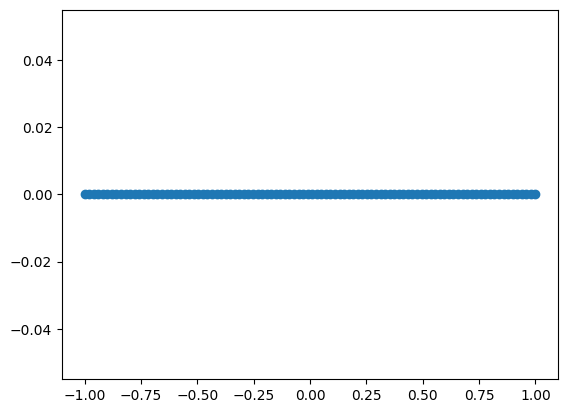

: 

: 

: 

In [ ]:
# Create adaptive grids for different properties
print("\n### Num of Electrons ###")
grid_e, weights_e, icosphere_orders_e = adaptive_grid(promol, "num_electrons")